In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

from plotter import *

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [4]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [ ]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
      infiles = json.load(f)
    
    filename = '/myeosdir/vbf-category/outfiles/'+year+'_'+str(n)+'.coffea'
    #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates-vbf'].scale(scale_lumi, 'dataset')
outsum['templates-vbf-2'].scale(scale_lumi, 'dataset')

templates = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates = templates_vbf.integrate('region','signal')
templates = templates_vbf.integrate('deta',int_range=slice(deta_cut,7.0))
templates.sum('pt1','msd1').integrate('ddb1',int_range=slice(0.89,1)).values()

del outsum
print('ok')

In [5]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [6]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [12]:
plot_mconly_vbf(templates.sum('mjj','qgl1','qgl2','msd1'),'deta','deta')

In [15]:
plot_mconly_vbf(templates.sum('deta','qgl1','qgl2','msd1'),'mjj','mjj')

In [18]:
plot_mconly_vbf(templates.sum('deta','mjj','qgl2','msd1'),'qgl1')

In [21]:
plot_mconly_vbf(templates.sum('deta','mjj','qgl1','msd1'),'qgl2')

In [24]:
templates_window=templates.sum('qgl1','qgl2').integrate('msd1',int_range=slice(mbb_min,mbb_max))

0.35639002757424837
[1000.     3.5]


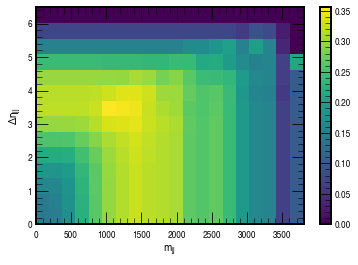

In [25]:
if year == '2017':

    cuts = []
    sigs = []

    deta_slices = [i*0.5 for i in range(0,14)]
    mjj_slices = [i*200 for i in range(0,20)]

    for deta in deta_slices:
        for mjj in mjj_slices:
            sliced = templates_window.integrate('deta',int_range=slice(deta,7)).integrate('mjj',int_range=slice(mjj,4000))
            s = sliced.values()[('VBF',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('ZH',)] + sliced.values()[('WH',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs += [significance(s,b)]
            cuts += [[mjj, deta]]
        
    cuts = np.array(cuts)
    print(max(sigs))
    print(cuts[np.argmax(sigs)])
    mjj_cut = cuts[np.argmax(sigs)][0]
    deta_cut = cuts[np.argmax(sigs)][1]

    plt.hist2d(cuts[:,0], cuts[:,1], density=False, weights=sigs, bins=[20,14]);
    plt.xlabel('$m_{jj}$');
    plt.ylabel('$\Delta\eta_{jj}$');
    plt.colorbar()
    plt.savefig(year+'/plot-all/vbfsigs_2d.png')
    
else:
    mjj_cut = 1000.
    deta_cut = 3.5

{'ttH': [0.04772687494693695], 'ZH': [0.030391472058933566], 'WH': [0.14978995471323825], 'VBF': [7.025612813349179], 'ggF': [1.9012383933571322], 'VV': [0.0], 'ttbar': [14.52850958165755], 'singlet': [4.667169517701365], 'Wjets': [3.2290866016901254], 'Zjets': [3.4357762157229375], 'QCD': [358.2884910859143]}


AttributeError: 'Rectangle' object has no property 'fill_opts'

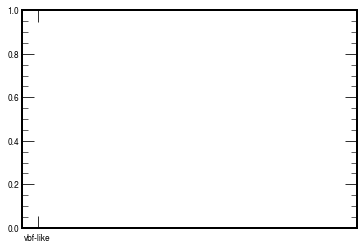

In [26]:
sr = templates_window.integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).values()
yield_plot(sr, 'vbf')

In [ ]:
# VBF significance
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]

print(significance(s,b))
# this only makes sense in the mass window of Higgs

In [ ]:
mhist = templates.sum('qgl1','qgl2').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_stack(mhist,'vbf-msd1')

In [ ]:
templates_cutflow = outsum['templates2'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region', 'signal').sum('qgl1','qgl2')

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.DataFrame(index=['$\Delta\eta_{jj}$','$m_{jj}$','DeepDoubleB'],columns=['ggF','VBF','WH','ZH','ttH'])
df2 = pd.DataFrame(index=['$\Delta\eta_{jj}$','$m_{jj}$','DeepDoubleB'],columns=['QCD','Wjets','Zjets','VV','ttbar','singlet'])

In [ ]:
# deta cut
tmp = templates_cutflow.sum('msd1','mjj','ddb1').integrate('deta',int_range=slice(deta_cut,7)).values()
cutname = '$\Delta\eta_{jj}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
# mjj cut
tmp = templates_cutflow.sum('msd1','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).values()
cutname = '$m_{jj}$'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
#ddb cut
tmp = templates_cutflow.sum('msd1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000)).integrate('ddb1',int_range=slice(0.89,1)).values()
cutname = 'DeepDoubleB'

df1['ggF'][cutname] = tmp[('ggF'),]
df1['VBF'][cutname] = tmp[('VBF'),]
df1['WH'][cutname] = tmp[('WH'),]
df1['ZH'][cutname] = tmp[('ZH'),]
df1['ttH'][cutname] = tmp[('ttH'),]

df2['QCD'][cutname] = tmp[('QCD'),]
df2['Wjets'][cutname] = tmp[('Wjets'),]
df2['Zjets'][cutname] = tmp[('Zjets'),]
df2['VV'][cutname] = tmp[('VV'),]
df2['ttbar'][cutname] = tmp[('ttbar'),]
df2['singlet'][cutname] = tmp[('singlet'),]

In [ ]:
print(df1)
df1 = df1.astype('int')
df1.to_latex(buf=year+'/cutflow-sig.tex')

In [ ]:
print(df2)
df2 = df2.astype('int')
df2.to_latex(buf=year+'/cutflow-bkg.tex')

In [ ]:
# Hard-coded -- combine results from all 3 years

tot_H = 0
VBF = 0

# 2016
tot_H += 1.32953 + 6.89172 + 0.121203 + 0.13017 + 0.0726312
VBF += 6.89172

# 2017
tot_H += 2.34718 + 8.93221 + 0.14979 + 0.0479135 + 0.083451
VBF += 8.93221

# 2018
tot_H += 2.94965 + 11.1321 + 0.18686 + 0.156234 + 0.100007
VBF += 11.1321

print(VBF/tot_H)

In [ ]:
np.sqrt(0.243**2 + 0.356**2 +  0.323**2)